# Estimating rainfall from radar data

## Radar data to rain intensity

The data we have available is a collection of 1024x1024 PNG images where the data at each pixel is related to the reflected power coming from the location represented by the pixel back to the radar. The actual position of each pixel can be inferred by using 'radarfootprint.tif' a GeoTiff image centered on the radar location.
The PNG image contains two bands, band0 with the actual signal and band1 with a mask array that is 0 where the signal should be zero and 255 everywhere else. The discretized signal, $D$, is bound to the related reflected power $P$ by

$$
D= (100 + P) * 2.55
$$

On the other hand, the reflected power $P$ is connected to $Z$, a quantity measured by the radar defined as 

$$
Z = \sum_d N_d  d^6 \delta d
$$

Where $N_d\delta d$ is the number of drops per cubic meter of diamater between $d$ and $d + \delta d$ mm.
The relation between $Z$ and $P$, assuming that the reflection happens at $r$ km away is given by

$$
Z = P + 91.4 + 20 \log(r)
$$

Where all the specific constants that characterize this specific radar have been subsumed in global constants.
Moreover, the (Marshall-Palmer distribution of raindrops)[https://doi.org/10.1016/0960-1686(93)90066-8] relates $Z$ to the related rainfall $R$ by

$$
Z = a R^b
$$

where, in our case,  $a=300$, $b=1.5$.

As a result, we can now invert the equations above to obtain a formula that relates the rainfall to $D$.

$$
Z = D/2.55 - 8.6 + 20 \log(r)
$$

Of course, given the relation above between $Z$ and $R$, when $Z < 0$, for instance weak signal closer than 2.7 km, the formula above becomes meaningless.

In [231]:
# imports and initializations
%matplotlib inline
import matplotlib.pyplot as plt
import gdal
import numpy as np
import imageio
import glob

In [232]:
class GeoAdapter(object):
    def __init__(self, footprint):
        self.footprint = footprint
    def get_grid(self, unit='km', send_raster=False):
        raster = gdal.Open(self.footprint)
        gt = raster.GetGeoTransform()
        oX, oY, pxlW, pxlH = gt[0], gt[3], gt[1], gt[5]
        cols, rows = raster.RasterXSize, raster.RasterYSize
        factor = {'km': 0.001, 'm': 1.0}[unit]
        if send_raster:
            return oX, oY, factor * pxlW, factor * pxlH, cols, rows, raster
        else:
            return oX, oY, factor * pxlW, factor * pxlH, cols, rows
    def save_as_raster(self, data, fname):
        oX, oY, pxlW, pxlH, cols, rows, oraster = self.get_grid(unit='m', send_raster=True)
        driver = gdal.GetDriverByName('GTiff')
        raster = driver.Create(fname, cols, rows, 1, gdal.GDT_Float32)
        raster.SetGeoTransform((oX, pxlW, 0, oY, 0, pxlH))
        band = raster.GetRasterBand(1)
        band.WriteArray(data)
        rasterSRS = osr.SpatialReference()
        rasterSRS.ImportFromWkt(oraster.GetProjectionRef())
        raster.SetProjection(rasterSRS.ExportToWkt())
        band.FlushCache()        

class SignalProcessor(object):
    def __init__(self, geo_adapter):
        self.distance_field = self.compute_distance_field(geo_adapter.get_grid(unit='km'))
    def compute_distance_field(self, details):
        oX, oY, pxlW, pxlH, cols, rows = details
        x = pxlW * (np.arange(-(cols/2), (cols/2), 1) + 0.5)
        y = pxlH * (np.arange(-(rows/2), (rows/2), 1) + 0.5)
        xx, yy = np.meshgrid(x, y, sparse=True)
        return 10 * np.log(xx**2 + yy**2)
    def process(self, data):
        signal, mask = data
        Z = (0.39216 * signal - 8.6 + self.distance_field) * mask
        return (0.003333 * Z * (Z > 0))**0.66666

class Aggregator(object):
    def __init__(self, path_root):
        self.path_root = path_root
    def aggregate(self, day, hour):
        return glob.glob('%s/%s_%s:*.png' % (self.path_root, day, hour))
    
class RainFallEstimator(object):
    def __init__(self, processor, aggregator):
        self.processor = processor
        self.aggregator = aggregator
    def get_image_data(self, path):
        im = imageio.imread(path)
        return im[:,:,0], im[:,:,3] == 255 # NOTE the mask is on channel 3!!!
    def get_precipitation(self, path):
        return self.processor.process(self.get_image_data(path))
    def aggregate(self, day, hour):
        paths = self.aggregator.aggregate(day, hour)
        precs = np.dstack([self.get_precipitation(x) for x in paths])
        return np.average(precs, axis=2)

In [233]:
ga = GeoAdapter('data/radarsample/radarfootprint.tif')

In [234]:
processor = SignalProcessor(ga)

In [235]:
aggregator = Aggregator("data/radarsample/cag01est2400")

In [236]:
rfe = RainFallEstimator(processor, aggregator)

In [237]:
signal, mask = rfe.get_image_data("data/radarsample/cag01est2400/2018-05-01_23:01:05.png")

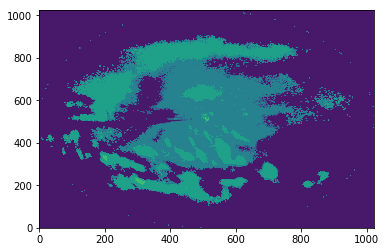

In [238]:
plt.contourf(signal)

In [239]:
rain = rfe.get_precipitation("data/radarsample/cag01est2400/2018-05-01_23:01:05.png")

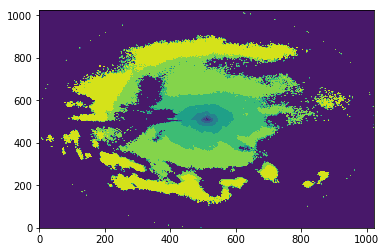

In [240]:
plt.contourf(rain)

In [241]:
ga.save_as_raster(rain, 'foobar.tif')

In [12]:
def extract_tfw(path):
    src = gdal.Open(path)
    xform = src.GetGeoTransform()
    return xform[1], xform[2], xform[4], xform[5], xform[0]+xform[1]/2, xform[3]+xform[5]/2

def extract_prj(path):
    src = gdal.Open(path)
    src_srs = osr.SpatialReference()
    src_srs.ImportFromWkt(src.GetProjection())
    src_srs.MorphToESRI()
    return src_srs.ExportToWkt()
# From https://gis.stackexchange.com/questions/139906/replicating-result-of-gdalwarp-using-gdal-python-bindings
def get_wkt(srs_code):
    # checks? we need no stinking checks!
    geo, code = srs_code.split(':')
    srs = osr.SpatialReference()
    # force geo to EPSG for the time being
    srs.ImportFromEPSG(int(code))
    return srs.ExportToWkt()

def warp(in_path, out_path, t_srs, s_srs=None):
    src_ds = gdal.Open(in_path)
    dst_wkt = get_wkt(t_srs)
    dst_srs = osr.SpatialReference()
    src_wkt = None if s_srs is None else get_wkt(s_srs)
    error_threshold = 0.125
    resampling = gdal.GRA_NearestNeighbour
    # Call AutoCreateWarpedVRT() to fetch default values for target raster dimensions and geotransform
    tmp_ds = gdal.AutoCreateWarpedVRT(src_ds,
                                      src_wkt,
                                      dst_wkt,
                                      resampling,
                                      error_threshold)
    # Create the final warped raster
    dst_ds = gdal.GetDriverByName('GTiff').CreateCopy(out_path, tmp_ds)

In [13]:
extract_tfw("data/radarsample/radarmappatipo.tif")

(60.0, 0.0, 0.0, -60.0, 1478729.0, 4372885.0)

In [14]:
extract_prj("data/radarsample/radarmappatipo.tif")

'PROJCS["Monte_Mario_Italy_zone_1",GEOGCS["GCS_Monte Mario",DATUM["D_Monte_Mario",SPHEROID["International_1924",6378388,297]],PRIMEM["Greenwich",0],UNIT["Degree",0.017453292519943295]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",9],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",1500000],PARAMETER["false_northing",0],UNIT["Meter",1]]'

In [41]:
! gdalwarp -rb -t_srs EPSG:4326 data/radarsample/radarmappatipo.tif foo_warped.tif

Creating output file that is 1148P x 891L.
Processing data/radarsample/radarmappatipo.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


In [42]:
warp("data/radarsample/radarmappatipo.tif", "radarmappatipo_warped.tif", "EPSG:4326", "EPSG:3003")

In [43]:
! gdalwarp -of GTiff -s_srs epsg:3003 -t_srs epsg:4326 data/radarsample/radarmappatipo.tif foo2_warped.tif

Creating output file that is 1148P x 891L.
Processing data/radarsample/radarmappatipo.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
